<a href="https://colab.research.google.com/github/DimaFrank/ML/blob/main/Copy_of_Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow
# !pip install nltk

In [44]:
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import words
import json
import pickle

from google.colab import drive

In [2]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [25]:
!ls /content/drive/MyDrive/ColabDatasets/

reviews_data.txt


In [4]:
file_path='/content/drive/MyDrive/ColabDatasets/reviews_data.txt'

# Read the reviews
reviews = []
with open(file_path, 'r', encoding='utf-8') as f:
    reviews = f.readlines()

# Remove newline characters
reviews = [review.strip() for review in reviews]

In [5]:
reviews=reviews[:50000]
reviews[0]

'oct nice trendy hotel location not too bad stayed in this hotel for one night as this is fairly new place some of the taxi drivers did not know where it was and or did not want to drive there once have eventually arrived at the hotel was very pleasantly surprised with the decor of the lobby ground floor area it was very stylish and modern found the reception staff geeting me with aloha bit out of place but guess they are briefed to say that to keep up the coroporate image as have starwood preferred guest member was given small gift upon check in it was only couple of fridge magnets in gift box but nevertheless nice gesture my room was nice and roomy there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by bliss the location is not great it is at the last metro stop and you then need to take taxi but if you are not planning on going to see the historic sites in beijing then you will be ok chose to have some breakfast in the

In [7]:
# Remove newline characters
reviews = [review.strip() for review in reviews]

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(reviews)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Tokenize the reviews
sequences = tokenizer.texts_to_sequences(reviews)



# Download the list of English words
nltk.download('words')
english_vocab = set(words.words())

def is_english_word(word):
    if isinstance(word, str):
        return word.lower() in english_vocab
    else:
        return False

stop_words = ['in', 'the', 'at', 'of', 'on', 'out', 'to', 'till', 'than', 'up', 'with', 'as', 'for', 'is', 'and', 'was', 'if', 'else']

# Create counter to count word frequencies
word_freq = Counter()
for sequence in sequences:
    word_freq.update(sequence)

# Determine number of words to remove
num_to_remove = int(0.1 * len(word_freq))

# Determine most frequent and least frequent words to remove
most_freq_words = set([w for w, _ in word_freq.most_common(num_to_remove)])
least_freq_words = set([w for w, _ in word_freq.most_common()[:-num_to_remove-1:-1]])


special_token = '<unk>'
# Filter out most frequent and least frequent words
sequences_filtered = []
for sequence in sequences:
    sequence_filtered = []
    for word in sequence:
        if word not in most_freq_words and word not in least_freq_words and is_english_word(word) and word not in stop_words:
            sequence_filtered.append(word)
        else:
            sequence_filtered.append(special_token)
    sequences_filtered.append(sequence_filtered)



# Replace special_token with a unique integer value
word_index = tokenizer.word_index
special_token_index = len(word_index) + 1
for i, sequence in enumerate(sequences_filtered):
    for j, word in enumerate(sequence):
        if word == special_token:
            sequences_filtered[i][j] = special_token_index
            special_token_index += 1


window_size = 2

# Create skip-gram pairs
skip_grams = []
for sequence in sequences_filtered:
    for i in range(window_size, len(sequence) - window_size):
        target_word = sequence[i]
        context_words = sequence[i - window_size : i] + sequence[i + 1 : i + window_size + 1]
        for context_word in context_words:
            skip_grams.append([target_word, context_word])

skip_grams = np.array(skip_grams, dtype=np.int32)




embedding_dim = 100

# Define input layers
input_target = tf.keras.layers.Input((1,))
input_context = tf.keras.layers.Input((1,))

# Define embedding layers
embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=1, name='embedding')
target = embedding(input_target)
target = tf.keras.layers.Reshape((embedding_dim, 1))(target)
context = embedding(input_context)
context = tf.keras.layers.Reshape((embedding_dim, 1))(context)

# Define dot product layer
dot_product = tf.keras.layers.Dot(axes=1)([target, context])
dot_product = tf.keras.layers.Reshape((1,))(dot_product)

# Define output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(dot_product)

# Define model
model = tf.keras.models.Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

epochs = 10
batch_size = 512

loss_errors=[]
for epoch in range(epochs):
    loss = 0
    for i in range(0, len(skip_grams), batch_size):
        batch = skip_grams[i:i+batch_size]
        target_word = batch[:, 0]
        context_word = batch[:, 1]
        label = np.ones(len(target_word))
        loss += model.train_on_batch([target_word, context_word], label)
        loss_errors.append(loss)
    print('Epoch:', epoch+1, 'Loss:', loss)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Epoch: 1 Loss: 1126.2969671506808
Epoch: 2 Loss: 0.0020634221484243653
Epoch: 3 Loss: 0.0020634221484243653
Epoch: 4 Loss: 0.0020634221484243653


KeyboardInterrupt: ignored

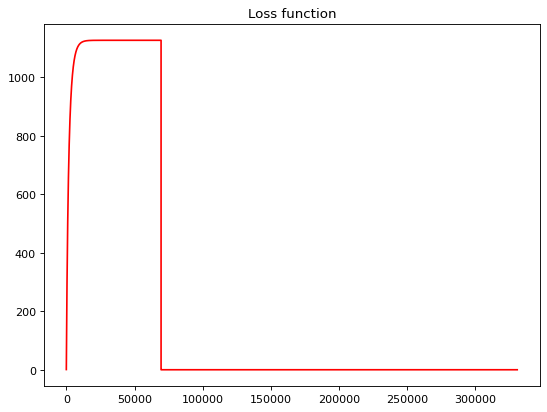

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

plt.plot(np.arange(len(loss_errors)), loss_errors, 'r')
plt.title('Loss function')
plt.show()

In [46]:
# Get the embedding matrix
embedding_matrix = model.get_layer('embedding').get_weights()[0]

# Save the embedding matrix to a file
np.save('/content/drive/MyDrive/ColabOutputs/embedding_matrix.npy', embedding_matrix)

# Save the tokenizer as pkl
with open('/content/drive/MyDrive/ColabOutputs/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(word, k=10):
    # Load the embedding matrix from the file
    embedding_matrix = np.load('/content/drive/MyDrive/ColabOutputs/embedding_matrix.npy')

    # Load the tokenizer from the file using pickle
    with open('/content/drive/MyDrive/ColabOutputs/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)

    # Get the embedding for the given word
    word_embedding = embedding_matrix[tokenizer.word_index[word]]

    # Compute the cosine similarity between the given word and all other words
    cosine_similarities = cosine_similarity([word_embedding], embedding_matrix)[0]

    # Get the indices of the k most similar words
    similar_word_indices = cosine_similarities.argsort()[-k-1:-1][::-1]

    # Get the words and their cosine similarity scores
    similar_words = [tokenizer.index_word[index] for index in similar_word_indices]
    similarity_scores = cosine_similarities[similar_word_indices]

    # Print the results
    print('Similar words for "{}":'.format(word))
    for i in range(len(similar_words)):
        print('  {}: {}'.format(similar_words[i], similarity_scores[i]))


find_most_similar('pub')

Similar words for "pub":
  wheretheir: 0.4561923146247864
  furnature: 0.42507511377334595
  inability: 0.4106626510620117
  remenber: 0.38685399293899536
  wasalready: 0.37322962284088135
  unbureocratic: 0.36752021312713623
  craned: 0.3596181273460388
  unfortunatly: 0.358915776014328
  else: 0.34987741708755493
  howbig: 0.3484119474887848


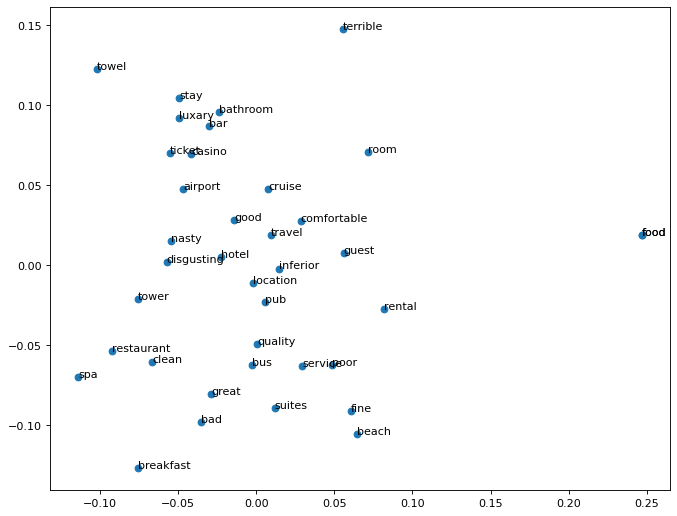

In [113]:
from sklearn.decomposition import PCA

figure(figsize=(10, 8), dpi=80)

# Get the embedding matrix
embedding_matrix = model.get_layer('embedding').get_weights()[0]

# Get the embeddings of the words we want to plot
words_to_plot = ['hotel', 'room', 'clean', 'comfortable', 'service', 'location', 'breakfast', 'bathroom', 'casino', 'luxary',
                 'restaurant', 'airport', 'suites', 'food', 'pub', 'rental', 'ticket', 'guest', 'cruise', 'bar', 'food', 'tower',
                 'spa', 'travel', 'stay', 'beach', 'towel', 'bus', 'good', 'great', 'fine', 'quality', 'bad', 'poor', 'inferior',
                 'terrible', 'nasty', 'disgusting']
word_embeddings = [embedding_matrix[tokenizer.word_index[word]] for word in words_to_plot]

# Use PCA to reduce the dimensionality of the embeddings to 2 dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(word_embeddings)

# Plot the embeddings in a scatter plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(words_to_plot):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()